In [98]:
"""
Constantes para definir la situación inicial del sistema

x_end: la gráfica será representada de -x_end a x_end
"""
x_end=100

"""
Potenciales   

tipop=
1- Barreras           altura_barrera: V0 barrera    ancho_barrera: barrera de [0,ancho]    
2- Barrera triangulo  altura_barrera: V0 máximo     ancho_barrera: barrera de [0,ancho]    
3- Barrera infinita   altura_barrera: ---           ancho_barrera: barrera de [0,ancho]    
4- Pozo infinito      altura_barrera: ---           ancho_barrera: pozo de [-a/2,a/2]     
5- Pozo finito        altura_barrera: V0 pozo       ancho_barrera: pozo de [-a/2,a/2]     
"""
tipop=1
altura_barrera=1
ancho_barrera=25.0

"""
Ondas iniciales

tipoo=
1- gausiana     sigma0: dispersión,   k0=momento inicial, x0: posición central inicial, x1:---
2- sinusoidal   sigma0: ---,          k0=momento inicial, x0: posición comienzo onda,   x1: posicion fin onda          
"""
tipoo=1
sigma0=0.5
k0=0.0
x0=-25
x1=25

"""
A partir de aquí es código
"""

%matplotlib notebook

import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import scipy as sp
from scipy.sparse import linalg as ln
from scipy import sparse as sparse
import matplotlib.animation as animation
import ipywidgets as wid
import animatplot as amp

class FunOnda:
    def __init__(self, tipop, tipoo, sigma0, k0, x0,x1, x_end,altura_barrera, ancho_barrera, n_points=500, dt=0.5):
        
        x_begin=-x_end
        self.n_points = n_points
        self.sigma0 = sigma0
        self.k0 = k0
        self.x0 = x0
        self.dt = dt
        self.tipop=tipop
        self.prob = np.zeros(n_points)
        self.ancho_barrera = ancho_barrera
        self.altura_barrera = altura_barrera
        
        """Array dimensional"""
        self.x, self.dx = np.linspace(x_begin, x_end, n_points, retstep=True) 
        
        """Creacion de la onda inicial"""
        
        if tipoo==1:
            self.norm = (100.0 * np.pi * sigma0**2)**(-0.25)
            self.psi = np.exp(-(self.x - x0)**2 / (4.0 * sigma0**2))
            self.psi = self.psi*np.exp(1.0j * k0 * self.x)
            self.psi = self.psi*(2.0 * np.pi * sigma0**2)**(-0.25)
            self.energy = np.array([self.norm*0.93*sigma0 for x in self.x])
        elif tipoo==2:
            self.norm=1
            self.psi = np.array([1 if x0<x<x1 else 0 for x in self.x])
            self.psi=self.psi*np.cos(k0*self.x)*100
            self.energy = np.array([k0**1/2/2 for x in self.x])
            
        """Creacion del potencial """
        if tipop==1:
            self.potential = np.array(
                [altura_barrera if 0.0 < x < ancho_barrera else 0.0 for x in self.x])
        elif tipop==2:
             self.potential = np.array(
                [altura_barrera*(1-abs((x-ancho_barrera/2.0))/(ancho_barrera/2)) if abs(x-ancho_barrera/2) < ancho_barrera/2 else 0.0 for x in self.x])
        elif tipop==3:
             self.potential = np.array(
                [10000000 if abs(x) < ancho_barrera/2 else 0.0 for x in self.x])
        elif tipop==4:
             self.potential = np.array(
                [0.0 if abs(x) < ancho_barrera/2 else 1000000 for x in self.x])
        elif tipop==5:
             self.potential = np.array(
                [0.0 if abs(x) < ancho_barrera/2 else altura_barrera for x in self.x])
                
                
        """Hamiltoniano"""
        h_diag = np.ones(n_points) / self.dx**2 + self.potential
        h_non_diag = np.ones(n_points - 1) * (-0.5 / self.dx**2)
        hamiltonian = sparse.diags([h_diag, h_non_diag, h_non_diag], [0, 1, -1])
         
        """Matriz evolucion temporal, metodo Crank-Nicolson """
        implicit = (sparse.eye(self.n_points) - dt / 2.0j * hamiltonian).tocsc()
        explicit = (sparse.eye(self.n_points) + dt / 2.0j * hamiltonian).tocsc() 
        self.evolution_matrix = ln.inv(implicit).dot(explicit).tocsr()
        
 
    def evolve(self):
        self.psi = self.evolution_matrix.dot(self.psi)
        self.prob = abs(self.psi)**2
 
        self.norm = sum(self.prob)
        self.prob /= self.norm
        self.psi /= self.norm**0.5
 
        return self.prob
 
class Animator:
    def __init__(self, onda):
        self.time = 0.0
        self.onda = onda
        self.fig, self.ax = plt.subplots()
        plt.plot(self.onda.x, self.onda.potential*0.7, color='r', label="Potencial (eV)")
        plt.plot(self.onda.x, self.onda.energy*0.7, color='g', label="Energía (eV)")
         
        self.time_text = self.ax.text(0.05, 0.95, '', horizontalalignment='left',
            verticalalignment='top', transform=self.ax.transAxes)
       
        self.ax.set_ylim(0, 1.1*self.onda.energy[0])
            
        self.line, = self.ax.plot(self.onda.x, self.onda.evolve(),label="Partícula")
        self.ax.set_xlabel('Posición (a$_0$)')
        self.ax.set_ylabel('Densidad de probabilidad (a$_0$)')
 
    def update(self, data):
        self.line.set_ydata(data)
        return self.line,
     
    def time_step(self):
        while True:

            self.time += self.onda.dt
            self.time_text.set_text(
                'Tiempo transcurrido: {:6.2f} fs'.format(self.time * 2.419e-2))

            yield self.onda.evolve()

    def animate(self):
        self.anim= animation.FuncAnimation(
            self.fig, self.update, self.time_step,interval=5, blit=False)
        anim = amp.Animation([block], timeline)
        plt.legend(loc='upper right')
        anim.controls()
        anim.save_gif('nuke')


        
onda=FunOnda(tipop,tipoo, sigma0, k0, x0,x1, x_end, altura_barrera, ancho_barrera)
animator = Animator(onda)
animator.animate()
plt.legend(loc='upper right')

plt.show()

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


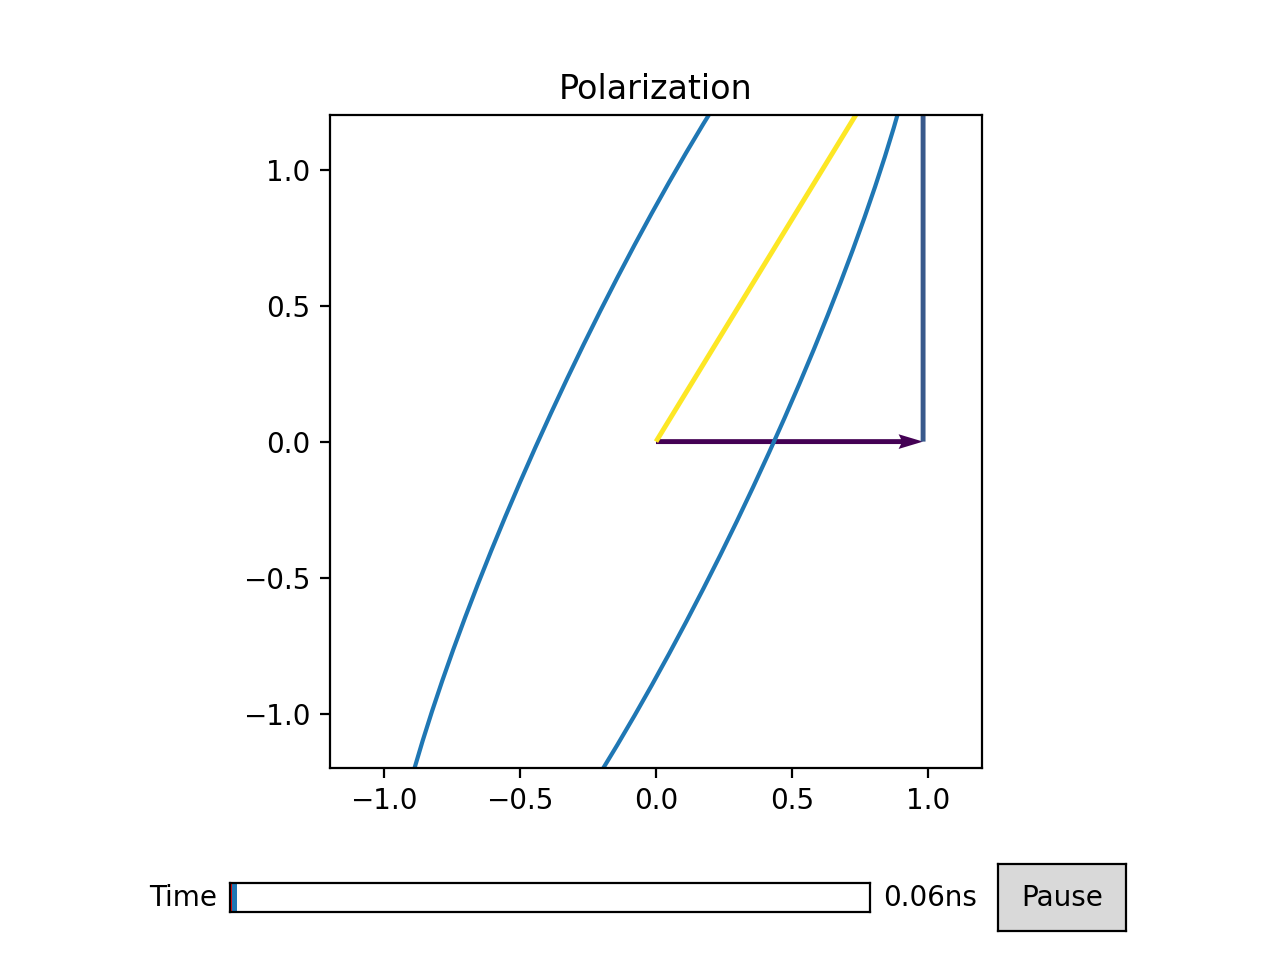

In [73]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import animatplot as amp

E0 = np.array([1, 2])
filter0 = E0 / np.linalg.norm(E0)

phi = np.array([0, np.pi/7])

f = 3
t = np.linspace(0,2*np.pi,100)

ES = E0[:, np.newaxis]*np.exp(1j*(t+phi[:, np.newaxis])) # fancy array boardcasting

fig, ax = plt.subplots()

def animate(i):
    ax.set_title('Polarization')
    ax.set_aspect('equal')
    ax.set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))

    E = E0*np.exp(1j*(f*t[i]+phi))

    xx = np.array([0,E[0].real,0])
    yy = np.array([0,0,0])
    uu = np.array([E[0].real,0,E[0].real])
    vv = np.array([0,E[1].real,E[1].real])

    plax = ax.plot(ES[0].real, ES.real[1])
    qax = ax.quiver(xx,yy,uu,vv,[0,55,200], scale_units='xy', scale=1.)

animate(0) # initialise the plot with the animate function

timeline = amp.Timeline(t, units='ns', fps=10)
block = amp.blocks.Nuke(animate, length=len(timeline), ax=ax)
anim = amp.Animation([block], timeline)

anim.controls()
anim.save_gif('nuke')
plt.show()